# SNR (Optimal) Generation Using Interpolation

This notebook provides a general guide on using the `gwsnr` package and its `GWSNR` class to generate the optimal signal-to-noise ratio (SNR) for given gravitational wave (GW) parameters using interpolation methods. For more details on the interpolation techniques, refer to the documentation section: [The Partial Scaling Interpolation Method](https://gwsnr.readthedocs.io/en/latest/interpolation.html).

The `gwsnr` package offers several interpolation methods:

1. **`interpolation`, `interpolation_no_spins`, `interpolation_no_spins_numba`**:  
    These methods use 2D cubic spline interpolation for the partial SNR with respect to mass ratio and total mass. `numba.njit` and `numba.prange` are utilized to accelerate the interpolation process and enable parallelization over GW parameter inputs.

2. **`interpolation_no_spins_jax`**:  
    Similar to the above, but uses `jax.jit` and `jax.vmap` to speed up the interpolation process and parallelization over both GW parameter inputs and detectors.

3. **`interpolation_aligned_spins`, `interpolation_aligned_spins_numba`**:  
    These methods employ 4D cubic spline interpolation for the partial SNR with respect to mass ratio, total mass, and aligned spins. `numba.njit` and `numba.prange` are used for performance optimization and parallelization.

4. **`interpolation_aligned_spins_jax`**:  
    Similar to the previous method, but leverages `jax.jit` and `jax.vmap` for efficient interpolation and parallelization over GW parameter inputs and detectors.

Interpolation type names are input as **`snr_type`** in the `GWSNR` class.


## Interpolation for Non Spinning Systems

- IMRPhenomD waveform model will be used for the interpolation method.
- You can either use `numba` or `jax` acceleration. Defult is `numba`. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gwsnr import GWSNR
from datetime import datetime

In [ ]:
# initializing the GWSNR class with default configuration and interpolation method
# for non-spinning IMRPhenomD waveform 
gwsnr_no_spins = GWSNR(
    snr_type='interpolation_no_spins', # or 'interpolation_no_spins_jax' (for jax acceleration)
    gwsnr_verbose=False,
    waveform_approximant='IMRPhenomD',
)

mass_1 = np.array([5, 10.,50.,100.])
ratio = np.array([1, 0.8,0.5,0.2])
dl = 1000
print('Interpolation results: ')
print(gwsnr_no_spins.snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=dl))
print('\n Inner product results: ')
print(gwsnr_no_spins.compute_bilby_snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=dl))


Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_2.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_2.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_2.pickle


Interpolation results: 
{'L1': array([ 7.40730953, 11.59680843, 31.03617859, 26.59852219]), 'H1': array([ 4.71128654,  7.37594223, 19.74000549, 16.91751289]), 'V1': array([2.22235346, 3.44041562, 9.33491135, 7.8612628 ]), 'optimal_snr_net': array([ 9.05556774, 14.1678133 , 37.94802856, 32.48819733])}

 Inner product results: 


/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.32it/s]

{'L1': array([ 7.40709512, 11.59602211, 31.03567109, 26.59869097]), 'H1': array([ 4.7111496 ,  7.37544125, 19.73968027, 16.91761888]), 'V1': array([2.22230853, 3.44041035, 9.33473625, 7.86132463]), 'optimal_snr_net': array([ 9.05531026, 14.16690812, 37.94739989, 32.48840739])}


### Checking speed and accuracy between the interpolation method and inner product method.

* set up the BBH Binary-Black-Holes parameters
* simulate 50000 events

In [3]:
# gerneral case, random parameters
# add random seed for reproducibility
np.random.seed(42)
nsamples = 50000
mtot = np.random.uniform(2*4.98, 2*112.5,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
param_dict = dict(
    # convert to component masses
    mass_1 = mtot / (1 + mass_ratio),
    mass_2 = mtot * mass_ratio / (1 + mass_ratio),
    # Fix luminosity distance
    luminosity_distance = 500*np.ones(nsamples),
    # Randomly sample everything else:
    theta_jn = np.random.uniform(0,2*np.pi, size=nsamples),
    ra = np.random.uniform(0,2*np.pi, size=nsamples), 
    dec = np.random.uniform(-np.pi/2,np.pi/2, size=nsamples), 
    psi = np.random.uniform(0,2*np.pi, size=nsamples),
    phase = np.random.uniform(0,2*np.pi, size=nsamples),
    geocent_time = 1246527224.169434*np.ones(nsamples),
)

In [7]:
# running it for the first time will take longer, as the jit code generate the compiled code
start_time_interp = datetime.now()
interp_snr_no_spins = gwsnr_no_spins.snr(gw_param_dict=param_dict)
end_time_interp = datetime.now()
print('Duration interpolation: {}'.format(end_time_interp - start_time_interp))

Duration interpolation: 0:00:00.038986


In [9]:
# this will take longer than the interpolation method, as it computes the inner product
# but it is more accurate
# it uses multiprocessing
start_time_inner = datetime.now()
bilby_snr = gwsnr_no_spins.compute_bilby_snr(gw_param_dict=param_dict)
end_time_inner = datetime.now()
print('Duration inner-product: {}'.format(end_time_inner - start_time_inner))

/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|███████████████████████████████████████████████████████| 50000/50000 [00:19<00:00, 2537.74it/s]

Duration inner-product: 0:00:19.840179


In [12]:
# time comparison, ratio
print(f"Time ratio (inner product / interpolation) = {(end_time_inner - start_time_inner) / (end_time_interp - start_time_interp)}")

Time ratio (inner product / interpolation) = 483.7652150590071


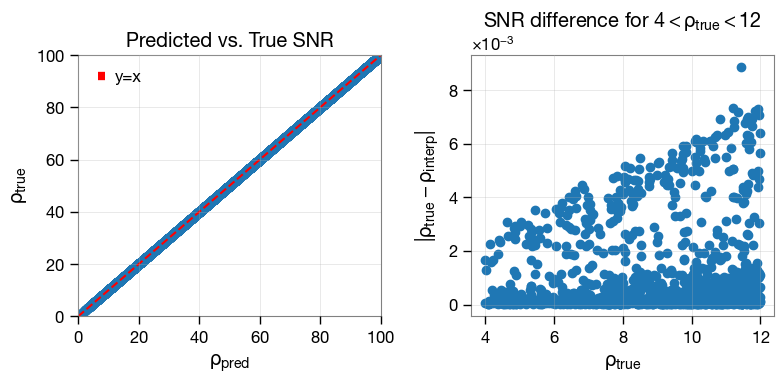

In [13]:
# compare the SNRs
plt.figure(figsize=(8,4))

# Left panel: rho_pred vs rho_true
plt.subplot(1, 2, 1)
plt.plot(bilby_snr['optimal_snr_net'], interp_snr_no_spins['optimal_snr_net'], 'o', color='C0')
# diagonal line
max_ = 100
min_ = 0
plt.plot([min_, max_], [min_, max_], 'r--', label='y=x')
plt.xlabel(r"$\rho_{pred}$")
plt.ylabel(r"$\rho_{true}$")
# plt.xscale('log')
# plt.yscale('log')
plt.xlim(min_, max_)
plt.ylim(min_, max_)
plt.legend()
plt.title(r"Predicted vs. True SNR")
plt.grid(alpha=0.4)

# Right panel: SNR difference
plt.subplot(1, 2, 2)
idx = (bilby_snr['optimal_snr_net'] > 4) & (bilby_snr['optimal_snr_net'] < 12)
plt.plot(bilby_snr['optimal_snr_net'][idx], abs(interp_snr_no_spins['optimal_snr_net'][idx]-bilby_snr['optimal_snr_net'][idx]), 'o', color='C0')
plt.xlabel(r"$\rho_{true}$")
plt.ylabel(r"$|\rho_{true} - \rho_{interp}|$")
plt.title(r"SNR difference")
plt.grid(alpha=0.4)
plt.title(r"SNR difference for $4 < \rho_{true} < 12$")
plt.tight_layout()  # Adjust layout to prevent overlapping titles/labels
plt.show()

In [16]:
# percentage difference
percent_diff = 100 * abs(interp_snr_no_spins['optimal_snr_net'] - bilby_snr['optimal_snr_net']) / bilby_snr['optimal_snr_net']
print(f"Mean percentage difference between interpolated and bilby SNRs: {np.mean(percent_diff):.2f}%")
print(f"Standard deviation of percentage difference: {np.std(percent_diff):.2f}%")
print(f"Median percentage difference: {np.median(percent_diff):.2f}%")
print(f"Max percentage difference: {np.max(percent_diff):.2f}%")
print(f"Min percentage difference: {np.min(percent_diff):.2f}%")

Mean percentage difference between interpolated and bilby SNRs: 0.01%
Standard deviation of percentage difference: 0.02%
Median percentage difference: 0.00%
Max percentage difference: 0.11%
Min percentage difference: 0.00%


## Interpolation for align-spins Systems

- IMRPhenomD with spin-aligned systems will be considered.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import gwsnr

In [2]:
# initializing the GWSNR class with default configuration and interpolation method
# for aligned-spinning IMRPhenomD waveform 
gwsnr_aligned_spins = gwsnr.GWSNR(
    snr_type='interpolation_aligned_spins_numba', # or 'interpolation_aligned_spins_jax' (for jax acceleration)
    gwsnr_verbose=False,
)

mass_1 = np.array([5, 10.,20.,30.])
ratio = np.array([1, 0.8,0.5,0.2])
a_1 = np.array([0.0, 0.2, 0.5, -0.7])
a_2 = np.array([0.0, -0.4, 0.5, 0.2])
dl = 1000* np.ones_like(mass_1)
print('Interpolation results: ')
print(gwsnr_aligned_spins.snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=dl, a_1=a_1, a_2=a_2))
print('\n Inner product results: ')
print(gwsnr_aligned_spins.compute_bilby_snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=dl, a_1=a_1, a_2=a_2))


Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_0.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_0.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_0.pickle


Interpolation results: 
{'L1': array([ 7.40731059, 11.51137388, 17.42773957, 11.28784101]), 'H1': array([ 4.71128664,  7.32160227, 11.08460023,  7.17942821]), 'V1': array([2.22235351, 3.41243431, 5.19701543, 3.28228624]), 'optimal_snr_net': array([ 9.05556885, 14.06279831, 21.29796794, 13.77435831])}

 Inner product results: 


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.51it/s]

{'L1': array([ 7.40709512, 11.51048787, 17.42610539, 11.28839655]), 'H1': array([ 4.7111496 ,  7.32103874, 11.08356084,  7.17978155]), 'V1': array([2.22230853, 3.41242961, 5.19684919, 3.28232586]), 'optimal_snr_net': array([ 9.05531026, 14.06177852, 21.29604919, 13.77500719])}


In [3]:
# gerneral case, random parameters
# add random seed for reproducibility
np.random.seed(0)
nsamples = 1000000
mtot = np.random.uniform(2*4.98, 2*112.5,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
param_dict = dict(
    # convert to component masses
    mass_1 = mtot / (1 + mass_ratio),
    mass_2 = mtot * mass_ratio / (1 + mass_ratio),
    # Fix luminosity distance
    luminosity_distance = 500*np.ones(nsamples),
    # Randomly sample everything else:
    theta_jn = np.random.uniform(0,2*np.pi, size=nsamples),
    ra = np.random.uniform(0,2*np.pi, size=nsamples), 
    dec = np.random.uniform(-np.pi/2,np.pi/2, size=nsamples), 
    psi = np.random.uniform(0,2*np.pi, size=nsamples),
    phase = np.random.uniform(0,2*np.pi, size=nsamples),
    geocent_time = 1246527224.169434*np.ones(nsamples),
    a_1 = np.random.uniform(-0.8,0.8, size=nsamples),
    a_2 = np.random.uniform(-0.8,0.8, size=nsamples),
)

In [5]:
# running it for the first time will take longer, as the jit code generate the compiled code
start_time_interp = datetime.now()
interp_snr_aligned_spins = gwsnr_aligned_spins.snr(gw_param_dict=param_dict)
end_time_interp = datetime.now()
print('Duration interpolation: {}'.format(end_time_interp - start_time_interp))

Duration interpolation: 0:00:01.337576


In [11]:
# this will take longer than the interpolation method, as it computes the inner product
# but it is more accurate
# it uses multiprocessing
start_time_inner = datetime.now()
bilby_snr = gwsnr_aligned_spins.compute_bilby_snr(gw_param_dict=param_dict)
end_time_inner = datetime.now()
print('Duration inner-product: {}'.format(end_time_inner - start_time_inner))

100%|███████████████████████████████████████████████████████| 50000/50000 [00:18<00:00, 2640.02it/s]


Duration inner-product: 0:00:19.065244


In [12]:
# time comparison, ratio
print(f"Time ratio (inner product / interpolation) = {(end_time_inner - start_time_inner) / (end_time_interp - start_time_interp)}")

Time ratio (inner product / interpolation) = 53.581599530095524


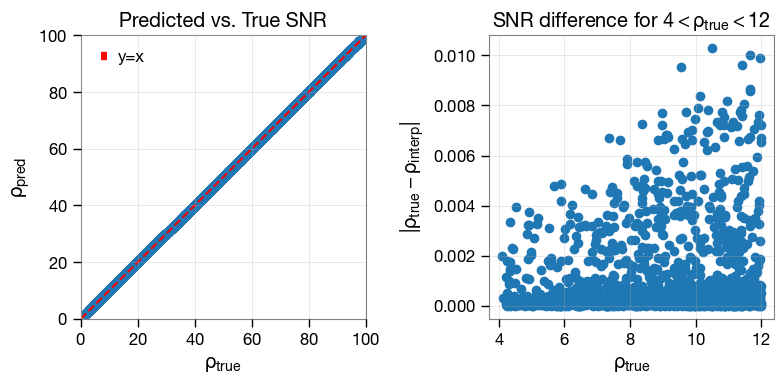

In [18]:
# compare the SNRs
plt.figure(figsize=(8,4))

# Left panel: rho_pred vs rho_true
plt.subplot(1, 2, 1)
plt.plot(interp_snr_aligned_spins['optimal_snr_net'], bilby_snr['optimal_snr_net'], 'o', color='C0')
# diagonal line
max_ = 100
min_ = 0
plt.plot([min_, max_], [min_, max_], 'r--', label='y=x')
plt.ylabel(r"$\rho_{pred}$")
plt.xlabel(r"$\rho_{true}$")
# plt.xscale('log')
# plt.yscale('log')
plt.xlim(min_, max_)
plt.ylim(min_, max_)
plt.legend()
plt.title(r"Predicted vs. True SNR")
plt.grid(alpha=0.4)

# Right panel: SNR difference
plt.subplot(1, 2, 2)
idx = (bilby_snr['optimal_snr_net'] > 4) & (bilby_snr['optimal_snr_net'] < 12)
plt.plot(bilby_snr['optimal_snr_net'][idx], abs(interp_snr_aligned_spins['optimal_snr_net'][idx]-bilby_snr['optimal_snr_net'][idx]), 'o', color='C0')
plt.xlabel(r"$\rho_{true}$")
plt.ylabel(r"$|\rho_{true} - \rho_{interp}|$")
plt.title(r"SNR difference")
plt.grid(alpha=0.4)
plt.title(r"SNR difference for $4 < \rho_{true} < 12$")
plt.tight_layout()  # Adjust layout to prevent overlapping titles/labels
plt.savefig('../_static/snr_comparison_interpolation.png', dpi=300)  # Save the figure
plt.show()

In [20]:
# percentage difference
percent_diff = 100 * abs(interp_snr_aligned_spins['optimal_snr_net'] - bilby_snr['optimal_snr_net']) / bilby_snr['optimal_snr_net']
print(f"Mean percentage difference between interpolated and bilby SNRs: {np.mean(percent_diff):.2f}%")
print(f"Standard deviation of percentage difference: {np.std(percent_diff):.2f}%")
print(f"Median percentage difference: {np.median(percent_diff):.2f}%")
print(f"Max percentage difference: {np.max(percent_diff):.2f}%")
print(f"Min percentage difference: {np.min(percent_diff):.2f}%")

Mean percentage difference between interpolated and bilby SNRs: 0.01%
Standard deviation of percentage difference: 0.02%
Median percentage difference: 0.00%
Max percentage difference: 0.61%
Min percentage difference: 0.00%


* The absolute difference between the SNR values from the interpolation method and the inner product method is still $\lesssim 0.01$ for all events.

* Note that interpolation accuracy is slightly higher for non-spinning systems compared to aligned-spin systems, and the computational speed-up factor is also generally higher for non-spinning systems.